# ENUNCIADO

- Implementar el detector de fondo naive usando la mediana como estimador. El algoritmo debe recibir el parámetro N (cantidad de frames utilizados para la estimación) y el intervalo de tiempo para recalcular el fondo.
- Se deben generar las mascaras de foreground y aplicarlas a los frames para segmentar los objetos en movimiento
- Comparar con alguno de los métodos vistos en la practica basados en mezcla de gaussianas

In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import copy
import matplotlib.pyplot as plt

## Algoritmo de sustraccion de fondo mediante MOG2 (como se presentó en la práctica)

In [2]:
backSub = cv.createBackgroundSubtractorMOG2()

In [3]:
# Abrimos el archivo
#-------------------
filename = 'vtest.avi' #'slow_traffic_small.mp4'
capture = cv.VideoCapture(filename)

fps = capture.get(cv.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
frame_count = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
duration = frame_count/fps
print(fps, frame_count, duration)

if not capture.isOpened:
    print('Falla al abrir el archivo: ' + filename)
    exit(0)

# Corremos la sustraccion
#------------------------
while True:
    # Leemos un frame
    ret, frame = capture.read()
    if frame is None:
        break
    
    # Aplicamos la sustracción al frame leído
    #----------------------------------------
    # Cada frame se utiliza tanto para calcular la máscara de primer plano como para actualizar el fondo.
    # Si se desea cambiar la tasa de aprendizaje utilizada para actualizar el modelo de fondo, es posible
    # establecer una tasa de aprendizaje específica pasando un parámetro al método apply.
    fgMask = backSub.apply(frame)
    
    # Escribimos sobre la imagen el número de frame procesado
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    # mostramos frame original e imagen binaria background/foreground
    cv.imshow('Frame', frame)
    cv.imshow('FG Mask', fgMask)
    
    # Corresmos hasta que termine o apriete escape
    keyboard = cv.waitKey(30)
    if keyboard == 'q' or keyboard == 27:
        break

cv.destroyAllWindows()
capture.release()

10.0 795 79.5


### Deteccion de moviemiento mediante MOG2 con frames elegidos al azar

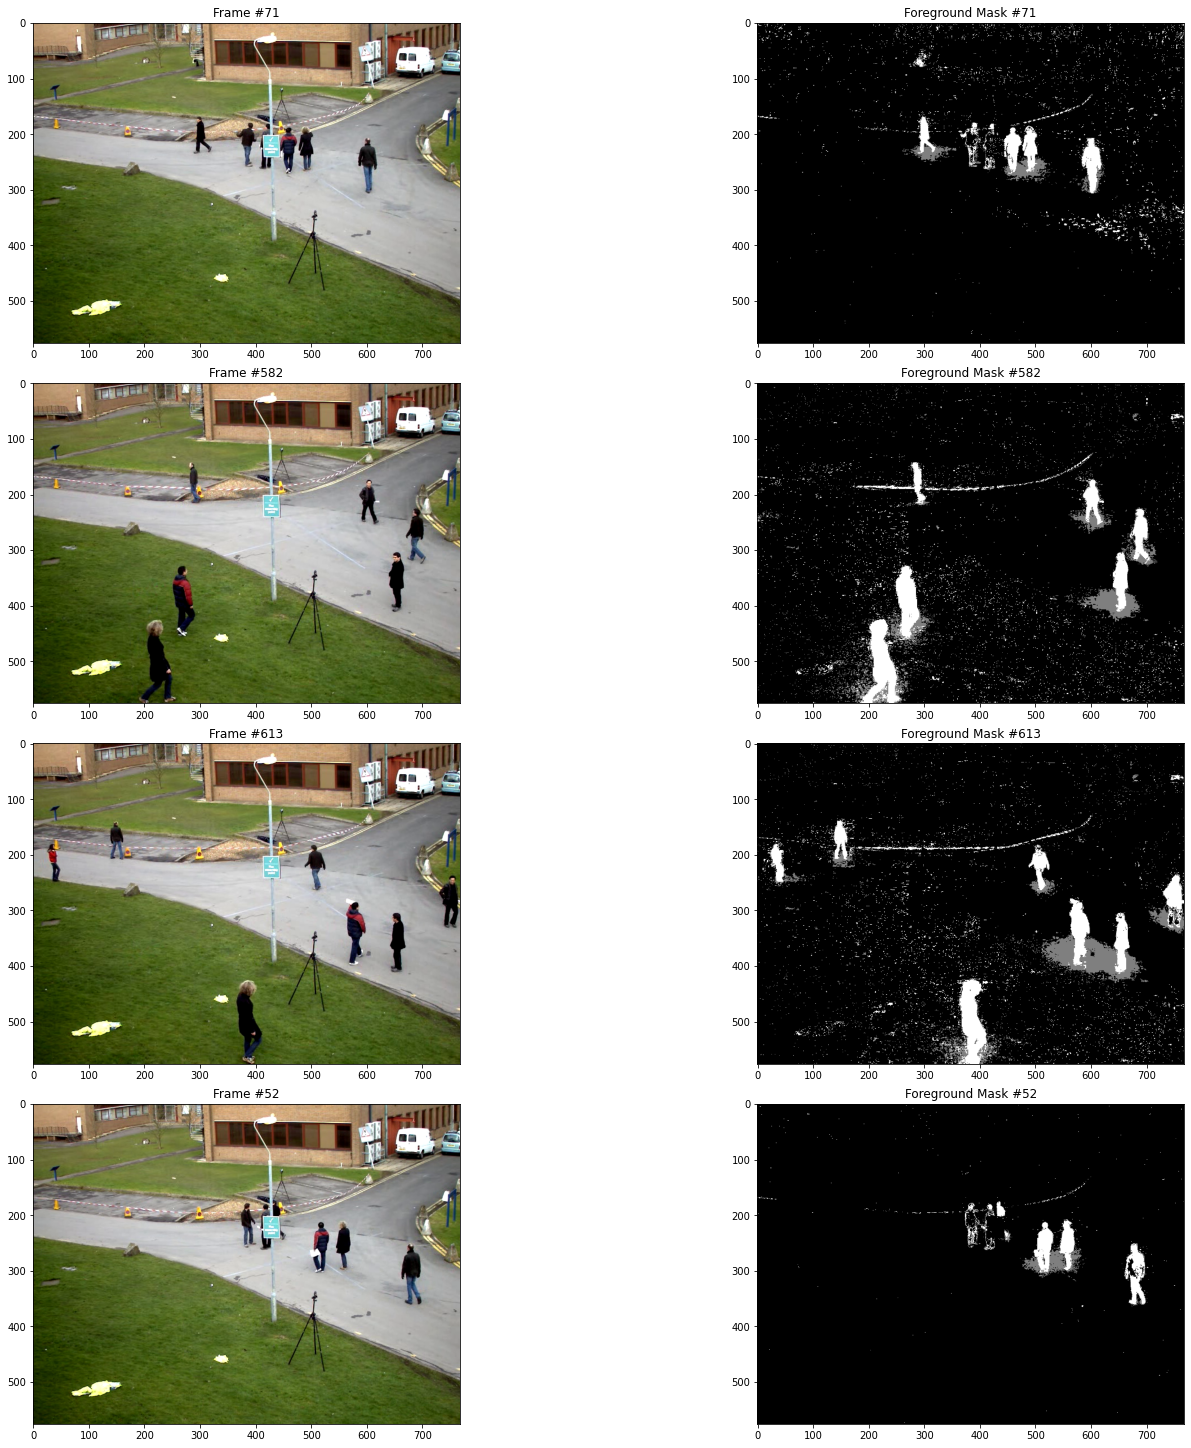

In [22]:
# Elijo frames aleatorios del video
nframes = 4
randomFrames = np.random.randint(0, frame_count, nframes)

# Obtengo la mascara de foreground para los frames seleccionados
fig, axs = plt.subplots(nframes, 2, constrained_layout=True, figsize=(20,20))
for i,rf in enumerate(randomFrames):
    capture.set(cv.CAP_PROP_POS_FRAMES, rf)
    _, frame = capture.read()
    
    fgMask = backSub.apply(frame)

    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)

    axs[i, 0].imshow(frame)
    axs[i, 0].set_title(f'Frame #{rf}')
    
    axs[i, 1].imshow(fgMask, cmap='gray')
    axs[i, 1].set_title(f'Foreground Mask #{rf}')

## Implementación de algoritmo Naive Background Subtraction

### Funciones auxiliares

In [25]:
def procesamientoMorfologico(thresh):
    
    # Creamos un elemento estructurante y aplicamos operaciones morfologicas
    kernel = np.ones((3,3), np.uint8)

    # Aplicamos una serie de iteraciones de apertura
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

    # Aplicamos una serie de iteraciones de cierre
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel, iterations=2)
    
    # Casteo el closing a "uint8"
    sure_fg = np.uint8(closing)
    
    return sure_fg

### Funcion para deteccion de fondo mediante método Naive Background Subtraction

In [26]:
def naiveBS(filename, frame, frame_count, median, N, pm):
    
    #-------------------------
    # Tamaño del fame actual
    h, w, _ = frame.shape
    
    # Si la mediana que la paso es "None" la calculo, sino utilizo la que paso como argumento
    if median is None:
    
        # Lista de capturas --> Repito N veces el objecto "capture" para no modificar el objeto original
        CAP = []
        for i in range(N):
            CAP.append(cv.VideoCapture(filename))

        #-------------------------
        # Genero una lista de N numeros aleatorios con los que selecciono los frames asociados
        indexes = np.random.randint(0, frame_count, N)
        rf_r = np.zeros((h,w,N))
        rf_g = np.zeros((h,w,N))
        rf_b = np.zeros((h,w,N))
        for i, idx in enumerate(indexes):
            cap = CAP[i]
            cap.set(cv.CAP_PROP_POS_FRAMES, idx)
            _, randomFrame = cap.read()
            rf_r[:, :, i] = randomFrame[:, :, 0]
            rf_g[:, :, i] = randomFrame[:, :, 1]
            rf_b[:, :, i] = randomFrame[:, :, 2]

        #-------------------------
        # Calculo la mediana de los frames aleatorios (canal a canal) y casteo a "uint8"
        median_r = np.median(rf_r, axis=2)
        median_g = np.median(rf_g, axis=2)
        median_b = np.median(rf_b, axis=2)
        median = np.dstack((median_r, median_g, median_b)).astype("uint8")
    
    #-------------------------
    # Resto la mediana al frame actual para obtener la máscara de foreground
    diff = cv.absdiff(frame, median) 
    
    #-------------------------
    # Ejecuto un desenfoque Gaussiano
    diff = cv.GaussianBlur(diff, (5,5), 2)

    #-------------------------
    # Paso a escala de grises, casteo a uint8, y binarizo
    gray = cv.cvtColor(diff, cv.COLOR_RGB2GRAY)
    _, fgMask = cv.threshold(gray.astype("uint8"), 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    #-------------------------
    # Procesamiento morfológico
    if pm==1:
        fgMask = procesamientoMorfologico(fgMask)
    
    
    return fgMask, median 

### Deteccion de moviemiento mediante Naive BS con los mismos frames elegidos al azar que con MOG2

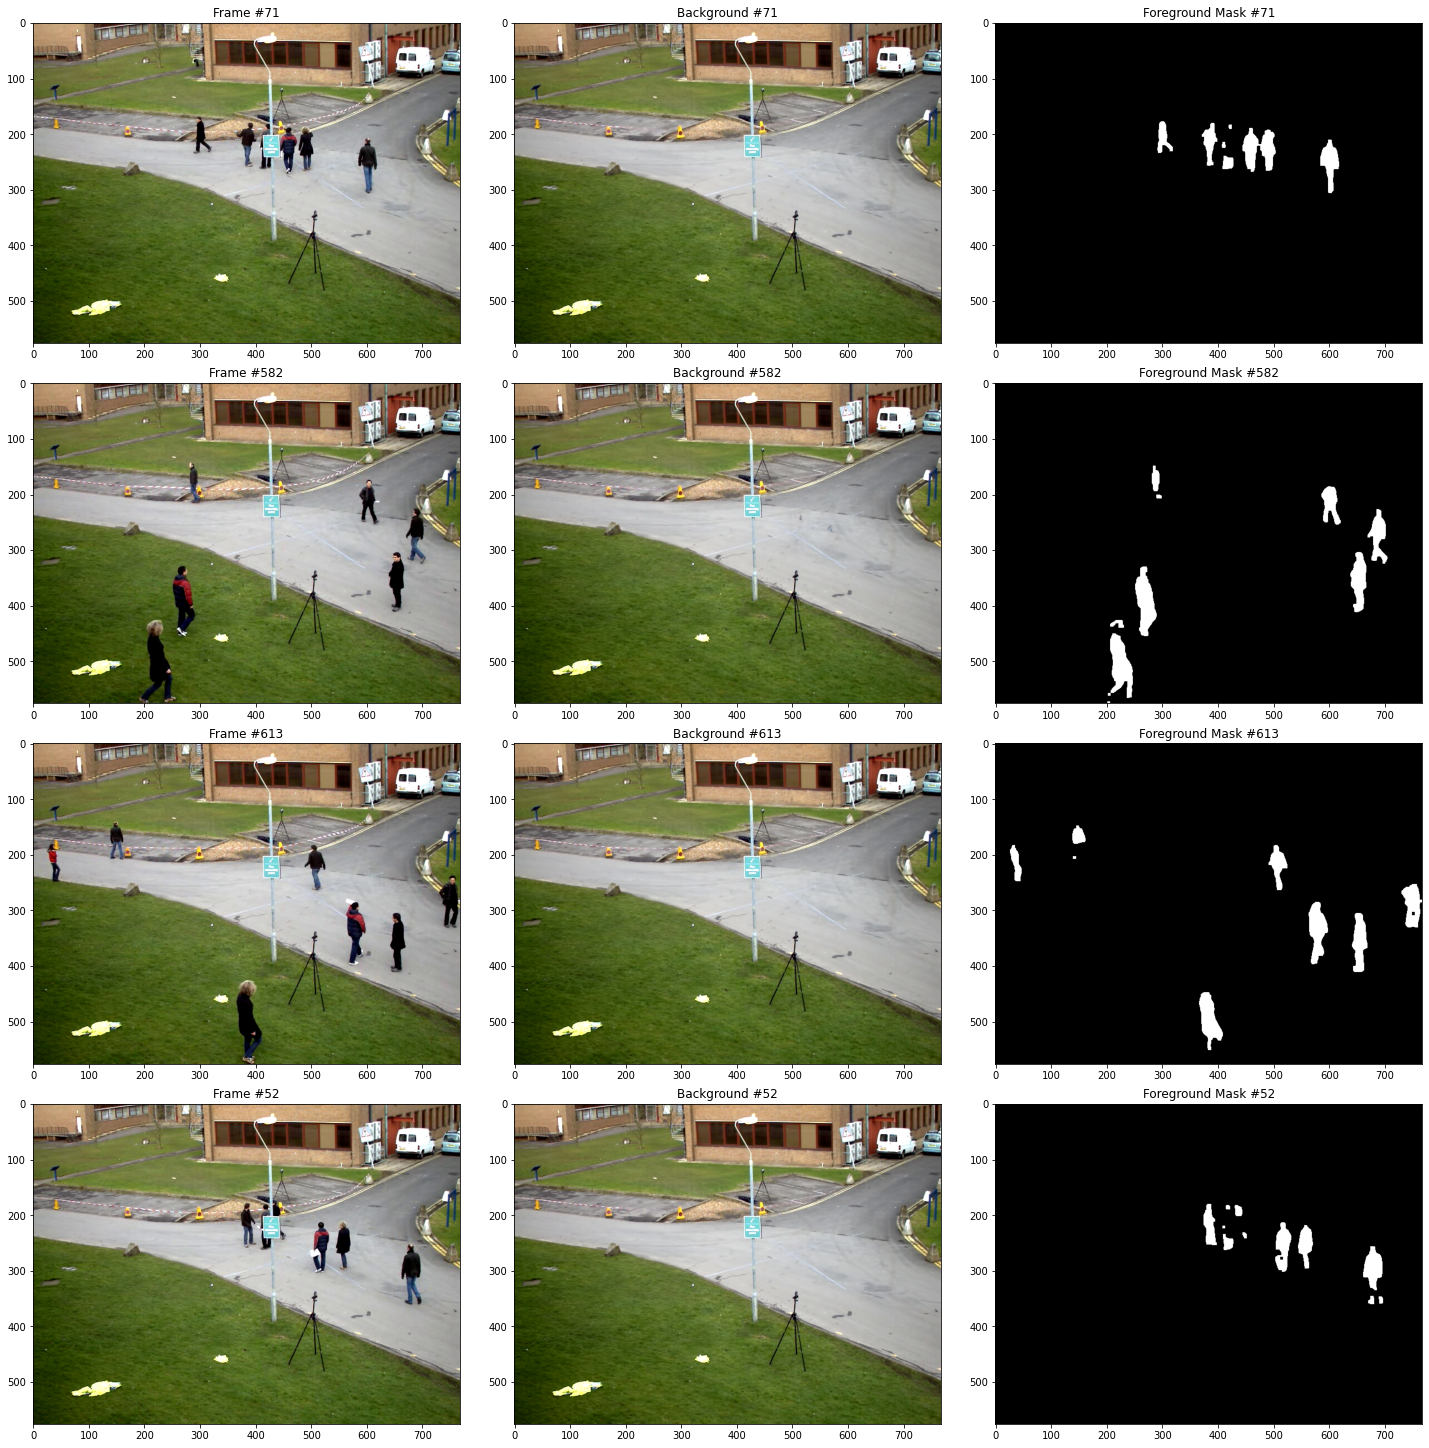

In [27]:
capture = cv.VideoCapture(filename)
frame_count = int(capture.get(cv.CAP_PROP_FRAME_COUNT))

#Cantidad de frames aleatorios a seleccionar
N = 10

# Obtengo el fondo y la mascara de foreground para los frames seleccionados
fig, axs = plt.subplots(nframes, 3, constrained_layout=True, figsize=(20,20))
for i,rf in enumerate(randomFrames):
    capture.set(cv.CAP_PROP_POS_FRAMES, rf)
    _, frame = capture.read()
    
    fg, bg = naiveBS(filename, frame, frame_count, None, N, 1)

    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)

    axs[i, 0].imshow(frame)
    axs[i, 0].set_title(f'Frame #{rf}')
    
    axs[i, 1].imshow(bg)
    axs[i, 1].set_title(f'Background #{rf}')
    
    axs[i, 2].imshow(fg, cmap='gray')
    axs[i, 2].set_title(f'Foreground Mask #{rf}')
    

### Corremos el algoritmo implementado sobre todo el video

In [28]:
# Parámetros para correr el método Naive
N = 10 #Cantidad de frames aleatorios a seleccionar
interval = 10 #Intervalo de tiempo (en segundos) donde la mediana calculada se mantiene constante

# Abro el archivo
#-------------------
#filename = 'slow_traffic_small.mp4'
capture = cv.VideoCapture(filename)

# Obtengo datos del video
fps = capture.get(cv.CAP_PROP_FPS)
frame_count = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
duration = frame_count/fps

# Inicializo la mediana como "None" para calcularla en el primer paso
median = None

# Indico si deseo aplicar procesamiento morfologico o no
pm = 1

# Corremos la sustraccion
#------------------------
cont = 1
while True:
    
    # Tiempo transcurrido
    elapsed_time = 1/fps*cont
    aux = np.mod(cont, int(fps*interval))
    
    # Leemos un frame
    ret, frame = capture.read()
    if frame is None:
        break
    
    # Si llego al limite del tiempo definido por el intervalo, vuelvo a definir la mediana como "None"
    if np.mod(cont, int(fps*interval))==0:
        median = None
    
    # Obtengo mediana y máscara
    fgMask, median = naiveBS(filename, frame, frame_count, median, N, pm) 
    
    # Escribimos sobre la imagen el número de frame procesado
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))
    
    # Mostramos frame original e imagen binaria background/foreground
    cv.imshow('Frame', frame)
    cv.imshow('FG Mask', fgMask)
    
    # Corremos hasta que termine o apriete escape
    keyboard = cv.waitKey(int(duration))
    if keyboard == 'q' or keyboard == 27:
        break
    
    # Actualizo contador
    cont += 1
    
cv.destroyAllWindows()
capture.release()

## Conclusiones

Se aprecia que claramente el algoritmo implementado permite obtener una segmentación clara de los objetos/personas en movimiento en relación al método MOG2. A su vez, la reconstrucción del fondo de la imagen es notoriamente precisa. La mejora en la detección del movimiento respecto a MOG2 fue posible gracias al empleo de técnicas de procesamiento morfológico que permitieron obtener máscaras de personas en movimiento bien definidas. Sin embargo, aún es posible realizar mejoras en la detección asignando valores diferentes a dichas funciones de procesamiento morfológico. El algoritmo implementado resulta bastante insensible frente a cambios en la cantidad de frames aleatorios a tomar en cada segmentación, como así tambien del tiempo de re-cálculo del fondo. Sin mebargo, tal característica puede verse afectada en escenas donde el fondo quede parcialmente ocluido en la mayor parte del video (por ejemplo, en videos de autopistas muy transitadas).